In [1]:
# Импорт необходимых модулей 
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Настройки для визуализации
# Если используется темная тема - лучше текст сделать белым
TEXT_COLOR = 'black'

matplotlib.rcParams['figure.figsize'] = (15, 10)
matplotlib.rcParams['text.color'] = 'black'
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['axes.labelcolor'] = TEXT_COLOR
matplotlib.rcParams['xtick.color'] = TEXT_COLOR
matplotlib.rcParams['ytick.color'] = TEXT_COLOR

# Зафиксируем состояние случайных чисел
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Случайные леса на Титанике

In [2]:
URL = 'https://raw.githubusercontent.com/KaiL4eK/ml_edu/master/datasets/Titanic_train.csv'
src_df = pd.read_csv(URL)
src_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
print(f'Shape of data: {src_df.shape}')
print(src_df.columns)

Shape of data: (891, 12)
Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


In [4]:
src_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## Базовый анализ данных

## Анализ признаков

In [5]:
print(src_df['PassengerId'].nunique())
print(src_df['PassengerId'].count())
src_df['PassengerId'].head()

891
891


0    1
1    2
2    3
3    4
4    5
Name: PassengerId, dtype: int64

## Заполнение пропусков

In [6]:
src_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Так, например, признак Age имеет 177 пропущенных значений, что является достаточно большим количеством, чтобы исключить записи с пропусками. Признак также невозможно исключить, так как он имеет информативный характер (возраст часто связывают со способностью к выживанию). Таким образом, можно воспользоваться sklearn.impute.SimpleImputer со стратегией заполнения mean, чтобы заполнить пропущенные данные на основе статистики остальных данных данного признака.

In [7]:
from sklearn.impute import SimpleImputer

imp = SimpleImputer(strategy='mean')
# Двойные скобки использованы, чтобы передать в fit() 2D массив
X_in = src_df[['Age']]
print(X_in.shape)

src_df['Age'] = imp.fit_transform(X_in)
src_df.isnull().sum()

(891, 1)


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Для категориальных признаков наиболее простым методом является стратегия most_frequent, когда берется наиболее частое значение:

In [8]:
imp = SimpleImputer(strategy='most_frequent')
src_df['Embarked'] = imp.fit_transform(src_df[['Embarked']])

src_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

Другим методом работы с пропусками является исключение признаков из-за слишком большого количества пропусков:

In [9]:
src_df['Cabin'].isnull().sum()/src_df.shape[0]

0.7710437710437711

## Кодирование признаков

Рассмотрим категориальный признак:

In [10]:
src_df.info()
src_df['Embarked'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


S    646
C    168
Q     77
Name: Embarked, dtype: int64

кодирование One-Hot

In [11]:
from sklearn.preprocessing import OneHotEncoder

# Мы отключим создание разреженного представления, но оно оптимальнее для хранения
# Поэтому для отладки лучше использовать и проверять dense представление,
#   а для работы в конечном представлении - sparse
oh_enc = OneHotEncoder(sparse=False)

# Любой энкодер ненавидит пропуски в данных, поэтому перед использованием
#   заполните пропуски в данных
X_sample = src_df[['Embarked']]
print(X_sample.shape)

oh_enc.fit(X_sample)

(891, 1)


OneHotEncoder(sparse=False)

In [12]:
# Можно проверить, какие есть категории
oh_enc.categories_

[array(['C', 'Q', 'S'], dtype=object)]

In [13]:
# Также посмотреть, что происходит после кодирования с данными
X_sample_ohe = oh_enc.transform(X_sample)

print(X_sample[:6])
print(X_sample_ohe[:6])

  Embarked
0        S
1        C
2        S
3        S
4        S
5        Q
[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]]


Поменяем False на True

In [14]:
from sklearn.preprocessing import OneHotEncoder

# Мы отключим создание разреженного представления, но оно оптимальнее для хранения
# Поэтому для отладки лучше использовать и проверять dense представление,
#   а для работы в конечном представлении - sparse
oh_enc_new = OneHotEncoder(sparse=True)

# Любой энкодер ненавидит пропуски в данных, поэтому перед использованием
#   заполните пропуски в данных
X_sample = src_df[['Embarked']]
print(X_sample.shape)

oh_enc_new.fit(X_sample)

(891, 1)


OneHotEncoder()

In [15]:
# Можно проверить, какие есть категории
oh_enc_new.categories_

[array(['C', 'Q', 'S'], dtype=object)]

In [16]:
# Также посмотреть, что происходит после кодирования с данными
X_sample_ohe = oh_enc_new.transform(X_sample)

print(X_sample[:6])
print(X_sample_ohe[:6])

  Embarked
0        S
1        C
2        S
3        S
4        S
5        Q
  (0, 2)	1.0
  (1, 0)	1.0
  (2, 2)	1.0
  (3, 2)	1.0
  (4, 2)	1.0
  (5, 1)	1.0


Еще одним важным аргументом является поведение энкодера при поступлении новых данных, которые он раньше не видел. Тут многое зависит от задачи, но можно сделать так, чтобы он выдавал ошибку или игнорировал новую категорию, которая не была в обучающих данных:

In [17]:
# Кидаем исключение, если появилась ранее невиданная категория
oh_enc = OneHotEncoder(sparse=False, handle_unknown='error')
oh_enc.fit(src_df[['Embarked']])

# Воспользуемся try-except, чтобы поймать ошибку
try:
    print(oh_enc.transform(np.array([['K']])))
except Exception as e:
    print(f'Error happened: {e}')

Error happened: Found unknown categories ['K'] in column 0 during transform


In [18]:
# Или просто игнорируем
oh_enc = OneHotEncoder(sparse=False, handle_unknown='ignore')
oh_enc.fit(src_df[['Embarked']])

# Воспользуемся try-except, чтобы поймать ошибку
try:
    print(oh_enc.transform(np.array([['K']])))
except Exception as e:
    print(f'Error happened: {e}')

[[0. 0. 0.]]


In [19]:
# Или просто игнорируем
oh_enc = OneHotEncoder(sparse=False, handle_unknown='ignore', categories=[['C', 'Q']])
X_sample = src_df[['Embarked']]
oh_enc.fit(X_sample)

X_sample_ohe = oh_enc.transform(X_sample)

print(X_sample[:6])
print(X_sample_ohe[:6])

  Embarked
0        S
1        C
2        S
3        S
4        S
5        Q
[[0. 0.]
 [1. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 1.]]


## Полноценная предобработка

Пайплайн позволяет собирать несколько этапов обработки/моделей воедино, чтобы затем пользоваться им как единым целым! Для примера наша обработка категориальных признаков может состоять из двух этапов

In [20]:
from sklearn.pipeline import Pipeline

categorical_features = ['Sex', 'Embarked']

# Создаем обработчик категориальный признаков
# Так как имеются пропущенные данные в Embarked - 
#   создадим Pipeline для выполнения нескольких шагов
categorical_transformer = Pipeline(
    # Шаги в Pipeline указываются как кортежи, каждый из которых
    #   представляет собой (имя шага, трансформер)
    steps=[
        ('imp', SimpleImputer(strategy='most_frequent')),
        # Опять sparse для отладки = False
        ('enc', OneHotEncoder(sparse=False, handle_unknown='error')),                   
])

In [21]:
URL = 'https://raw.githubusercontent.com/KaiL4eK/ml_edu/master/datasets/Titanic_train.csv'
df = pd.read_csv(URL)

categorical_transformer.fit(df[categorical_features])

X_transformed = categorical_transformer.transform(df[categorical_features])
print(df[categorical_features][:3])
print(X_transformed[:3])

      Sex Embarked
0    male        S
1  female        C
2  female        S
[[0. 1. 0. 0. 1.]
 [1. 0. 1. 0. 0.]
 [1. 0. 0. 0. 1.]]


In [22]:
# До конкретных шагов можно добраться через атрибут named_steps
categorical_transformer.named_steps['enc'].categories_

[array(['female', 'male'], dtype=object), array(['C', 'Q', 'S'], dtype=object)]

In [23]:
# Или посмотреть названия признаков после кодирования
categorical_transformer.named_steps['enc'].get_feature_names(categorical_features)

array(['Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype=object)

Теперь перейдем к другому классу - преобразователь колонок! Его применение в том, чтобы также собирать шаги обработки, но уже указывая, на какие колонки, какая обработка. То есть в пайплайн мы явно передавали данные. ColumnTransformer позволяет настроить всю линию предобработки, указывая, какую колонку, чем обрабатывать:

In [24]:
from sklearn.compose import ColumnTransformer

# Составляет список признаков для обработки
categorical_features = ['Sex', 'Embarked']
numeric_features = ['Age', 'Fare']

# Создаем обработчик категориальных признаков
categorical_transformer = Pipeline(
    steps=[
        ('imp', SimpleImputer(strategy='most_frequent')),
        ('enc', OneHotEncoder(handle_unknown='error')),                   
])

# Численные значения имеют пропуски, заполним стратегией медианы
numeric_transformer = SimpleImputer(strategy='median')

# Создаем конечный конвертер, который будет использован для 
#   предобработки
preprocessor = ColumnTransformer(
    # Список конвертеров, каждый кортеж содержит
    #   имя, конвертер и признаки, на которые он будет применен
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numeric_transformer, numeric_features)
    ],
    # Признаки, не указанные ни в одном из конвертеров будут удалены
    remainder='drop'
)

preprocessor.fit(df)

X_data = preprocessor.transform(df)
print(type(X_data))

<class 'numpy.ndarray'>


На выходе конвертера получается числовая матрица numpy, которую можно уже передавать на вход модели. При этом трансформер колонок позволяет также получать доступ до своих составляющих через атрибут named_transformers_:

In [25]:
# Получим объект пайплайна категориальных признаков
pipe = preprocessor.named_transformers_['cat']
# Отобразим категории OHE для шага кодирования
print(pipe.named_steps['enc'].categories_)

[array(['female', 'male'], dtype=object), array(['C', 'Q', 'S'], dtype=object)]


In [26]:

# Для того, чтобы получить имена признаков, воспользуемся функцией
#   OneHotEncoder.get_feature_names()
# Чтобы ею воспользоваться, необходимо добраться до объекта через атрибуты
#   - ColumnTransformer.named_transformers_ + ключ имени
#   - Pipeline.named_steps + ключ шага
ohe_column_names = preprocessor \
    .named_transformers_['cat'] \
    .named_steps['enc'] \
    .get_feature_names(categorical_features)

recovered_feat_names = \
    list(ohe_column_names) + \
    list(numeric_features)

df_enc = pd.DataFrame(X_data, columns=recovered_feat_names)

df_enc.head()

,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Age,Fare
0,0.0,1.0,0.0,0.0,1.0,22.0,7.2500
1,1.0,0.0,1.0,0.0,0.0,38.0,71.2833
2,1.0,0.0,0.0,0.0,1.0,26.0,7.9250
3,1.0,0.0,0.0,0.0,1.0,35.0,53.1000
4,0.0,1.0,0.0,0.0,1.0,35.0,8.0500


In [27]:
# Для сравнения выведем исходные данные
df[categorical_features + numeric_features].head()

,Sex,Embarked,Age,Fare
0,male,S,22.0,7.2500
1,female,C,38.0,71.2833
2,female,S,26.0,7.9250
3,female,S,35.0,53.1000
4,male,S,35.0,8.0500


## Разработка модели случайного леса

[Text(418.5, 453.0, 'X[0] <= 0.5\ngini = 0.5\nsamples = 4\nvalue = [2, 2]\nclass = 0'),
 Text(209.25, 271.8, 'X[1] <= 0.5\ngini = 0.5\nsamples = 2\nvalue = [1, 1]\nclass = 0'),
 Text(104.625, 90.59999999999997, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]\nclass = 0'),
 Text(313.875, 90.59999999999997, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]\nclass = 1'),
 Text(627.75, 271.8, 'X[1] <= 0.5\ngini = 0.5\nsamples = 2\nvalue = [1, 1]\nclass = 0'),
 Text(523.125, 90.59999999999997, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]\nclass = 1'),
 Text(732.375, 90.59999999999997, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]\nclass = 0')]

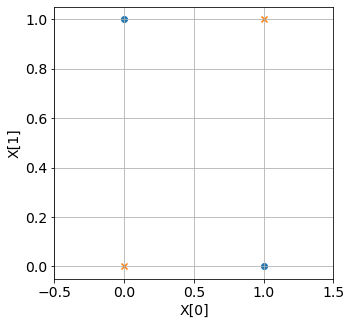

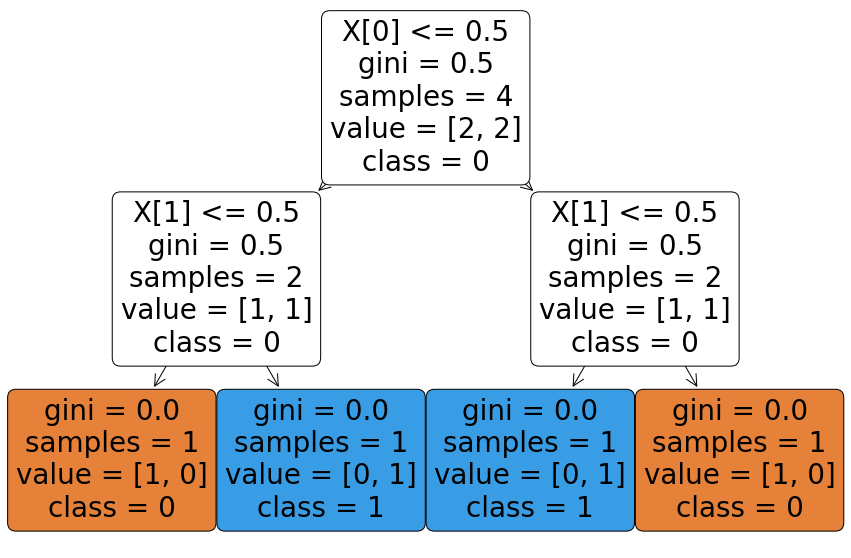

In [28]:
import numpy as np

# Пример решающего дерева на основе задачи XOR
X = np.array([
     [1, 1],
     [1, 0],
     [0, 1],
     [0, 0]
])

y = np.array([
     0,
     1,
     1,
     0
])

plt.figure(figsize=[5,5])
plt.scatter(X[y==1, 0], X[y==1, 1], marker='o')
plt.scatter(X[y==0, 0], X[y==0, 1], marker='x')
plt.xlabel('X[0]')
plt.ylabel('X[1]')
plt.xlim([-0.5, 1.5])
plt.grid()

from sklearn.tree import DecisionTreeClassifier, plot_tree

tree = DecisionTreeClassifier(random_state=42)
tree.fit(X, y)

plt.figure()
plot_tree(tree, filled=True, rounded=True, impurity=True, class_names=['0', '1'])

при построении каждого малого дерева используется подвыборка, куда могут попадать с повторениями случайные записи из данных со случайными признаками. Таким образом, каждая модель будет видеть лишь часть данных, при этом отдельно каждая слабая модель будет работать плохо, но в совокупности все модели будут давать более точную среднюю оценку в соответсвии с принятием решения по большинству голосов.

In [29]:
from sklearn.model_selection import train_test_split

TRAIN_RATIO = 0.8

y_data = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, 
    train_size=TRAIN_RATIO, 
    random_state=RANDOM_STATE,
    stratify=y_data
)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(712, 7) (712,)
(179, 7) (179,)


In [30]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)

RandomForestClassifier()

## Важность признаков

Feature: Sex_female | 0.15224129686733381
Feature: Sex_male | 0.14384419737286344
Feature: Embarked_C | 0.011105298934466924
Feature: Embarked_Q | 0.004819245681205841
Feature: Embarked_S | 0.013524060985120172
Feature: Age | 0.2941428805908806
Feature: Fare | 0.3803230195681293


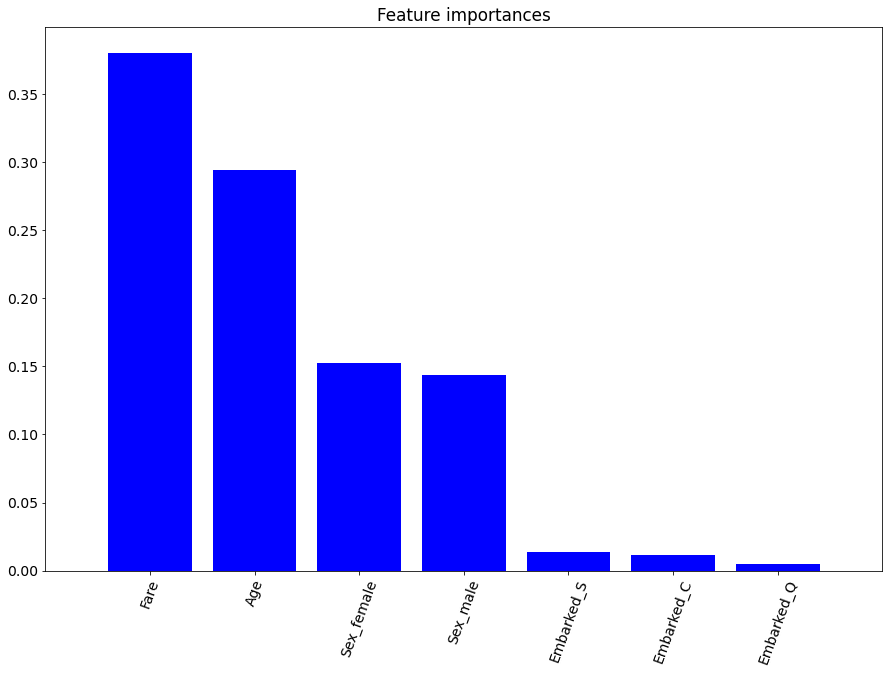

In [31]:

def show_importance(model, feature_names, X):
    importances = model.feature_importances_
    for feat_imp, feat_name in zip(importances, feature_names):
        print(f'Feature: {feat_name} | {feat_imp}')

    indices = np.argsort(importances)[::-1]
    sorted_feat_names = [feature_names[ind] for ind in indices]

    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices], color="b", align="center")
    plt.xticks(range(X.shape[1]), sorted_feat_names, rotation=70)
    plt.xlim([-1, X.shape[1]])
    plt.show()

show_importance(rf_clf, recovered_feat_names, X_train)

## Расширенный анализ данных

Один из самых простых способов проверить пользу признака - анализ нескольких признаков в совокупности, чтобы понять, какие взаимосвязи имеются и дает ли признак информацию. Начнем с того, что постараемся определить, кто чаще выживает - мужчины или женщины:

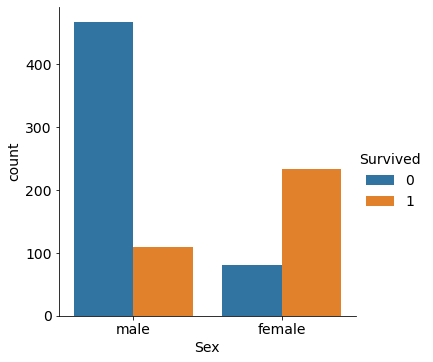

In [32]:
sns.catplot(x="Sex", hue="Survived", kind="count", data=df)

Еще одним интересный признак Pclass, класс обслуживания, можно проверить, влияет ли он на выживаемост

<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

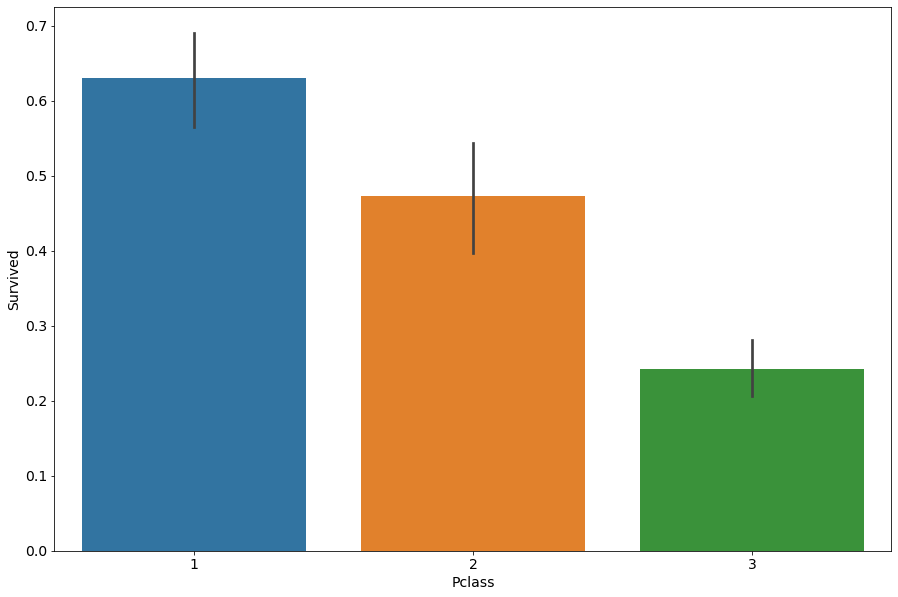

In [33]:
sns.barplot(x='Pclass', y='Survived', data=df)

Также можно влияние признака проверить отображением через sns.FacetGrid, чтобы проверить все значения, связанные с несколькими признаками:

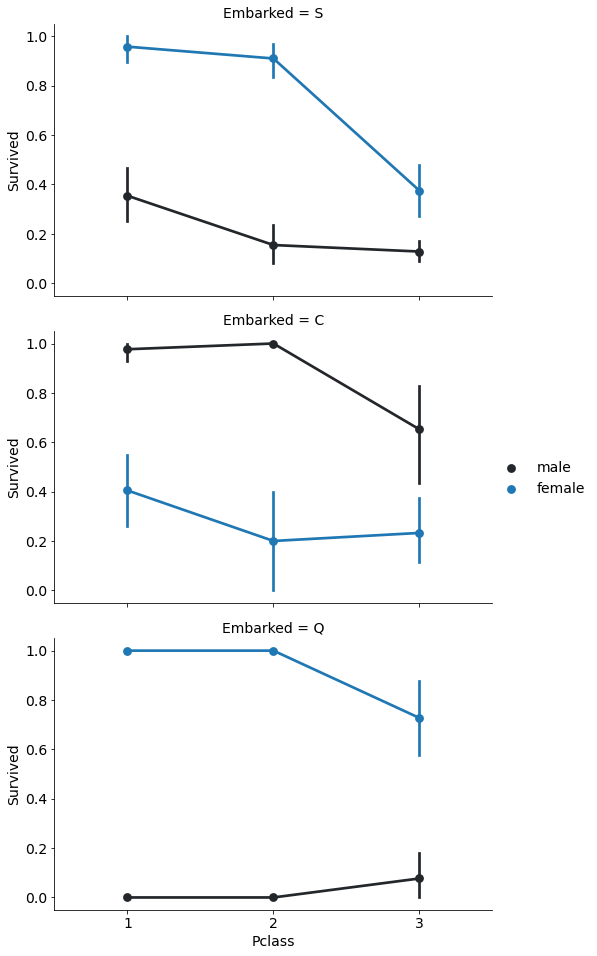

In [34]:
FacetGrid = sns.FacetGrid(df, row='Embarked', height=4.5, aspect=1.6)
FacetGrid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette=None,  order=None, hue_order=None)
FacetGrid.add_legend()

## Создание новых признаков

Помимо исключения признаков одним из широкоприменяемых подходов является создание новых признаков. Для примера, наличие двух признаков SibSp и Parch сообщает информацию о количестве родственников на борту. Таким образом, можно сформировать дополнительный признак FamilySize.

In [35]:
# +1 - we are in family too
df['FamilySize'] = df['Parch'] + df['SibSp'] + 1

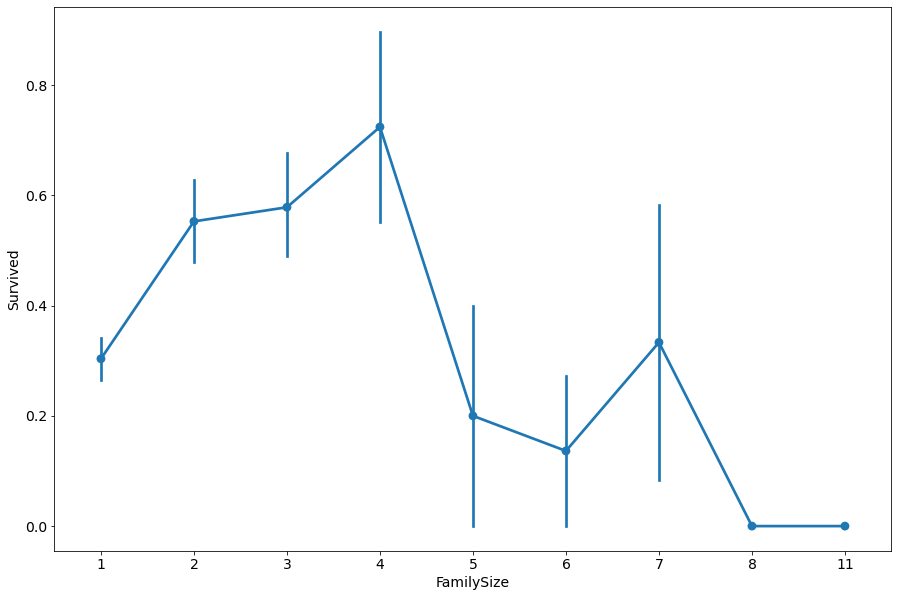

In [36]:
axes = sns.pointplot(x='FamilySize', y='Survived', data=df)

## Группировка данных (binning)

C:\Users\ksyus\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Fare', ylabel='Density'>

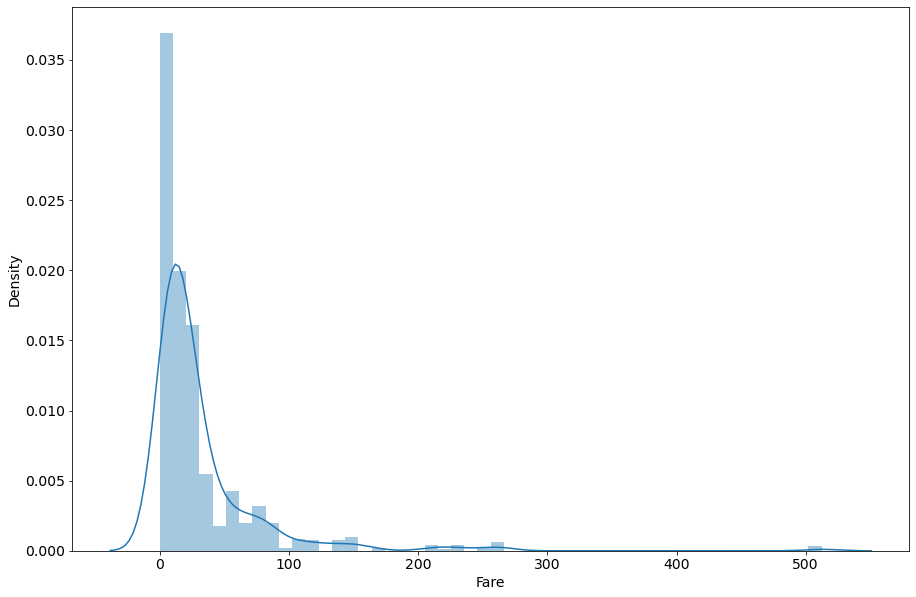

In [37]:
sns.distplot(df['Fare'], bins=50)

Раcпределение немного сдвинуто влево, также слева имеется небольшая мода. Для группировки воспользуется классом KBinsDiscretizer, который разделяет весь диапазон на заданное количество групп (бинов).

[array([  0.    ,   7.55  ,   7.8542,   8.05  ,  10.5   ,  14.4542,
        21.6792,  27.    ,  39.6875,  77.9583, 512.3292])]


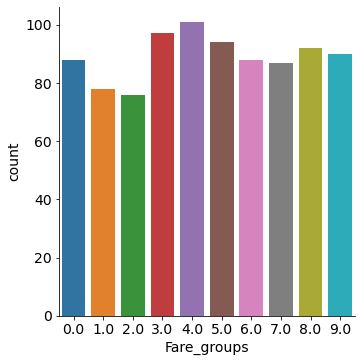

In [38]:
from sklearn.preprocessing import KBinsDiscretizer

discr = KBinsDiscretizer(
    # Количество бинов    
    n_bins=10,
    # Способ кодирования - порядковый
    encode='ordinal',
)

# Двойные скобки для передачи DataFrame (2D данные)
df['Fare_groups'] = discr.fit_transform(df[['Fare']])
# Отобразим границы бинов
print(discr.bin_edges_)

sns.catplot(x='Fare_groups', kind="count", data=df)

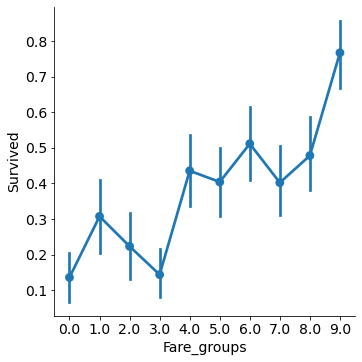

In [39]:
sns.catplot(x='Fare_groups', y='Survived', data=df, kind='point')

## Поиск гиперпараметров

In [40]:
from sklearn.model_selection import GridSearchCV

parameters = {
    'max_depth': [1, 2, 4, 5, 7],
    'n_estimators': [1, 5, 10, 20, 40],
}

grid_search = GridSearchCV(
    # модель
    estimator=rf_clf,                   
    # сетка параметров
    #   может быть объектом dict 
    #   или list с несколькими dict внутри (несколько сеток)
    param_grid=parameters,              
    # кол-во фолдов для CV
    cv=5,                               
    # метрика для оценки - используем F1 
    scoring='f1_macro',   
)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [1, 2, 4, 5, 7],
                         'n_estimators': [1, 5, 10, 20, 40]},
             scoring='f1_macro')

In [41]:
# Для поиска параметров модели внутри пайплайна используется специальное именование:
#   <название шага>__<название параметра>
pipe = Pipeline(steps=[
    ('clf', RandomForestClassifier()),
])

# В названии два подчеркивания!
parameters = {
    'clf__max_depth': [1, 2, 4, 5, 7],
    'clf__n_estimators': [1, 5, 10, 20, 40],
}

grid_search = GridSearchCV(
    # пайплайн
    estimator=pipe,                   
    param_grid=parameters,              
    cv=5,                               
    scoring='f1_macro',   
)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('clf', RandomForestClassifier())]),
             param_grid={'clf__max_depth': [1, 2, 4, 5, 7],
                         'clf__n_estimators': [1, 5, 10, 20, 40]},
             scoring='f1_macro')

In [42]:
grid_search.cv_results_['params']

[{'clf__max_depth': 1, 'clf__n_estimators': 1},
 {'clf__max_depth': 1, 'clf__n_estimators': 5},
 {'clf__max_depth': 1, 'clf__n_estimators': 10},
 {'clf__max_depth': 1, 'clf__n_estimators': 20},
 {'clf__max_depth': 1, 'clf__n_estimators': 40},
 {'clf__max_depth': 2, 'clf__n_estimators': 1},
 {'clf__max_depth': 2, 'clf__n_estimators': 5},
 {'clf__max_depth': 2, 'clf__n_estimators': 10},
 {'clf__max_depth': 2, 'clf__n_estimators': 20},
 {'clf__max_depth': 2, 'clf__n_estimators': 40},
 {'clf__max_depth': 4, 'clf__n_estimators': 1},
 {'clf__max_depth': 4, 'clf__n_estimators': 5},
 {'clf__max_depth': 4, 'clf__n_estimators': 10},
 {'clf__max_depth': 4, 'clf__n_estimators': 20},
 {'clf__max_depth': 4, 'clf__n_estimators': 40},
 {'clf__max_depth': 5, 'clf__n_estimators': 1},
 {'clf__max_depth': 5, 'clf__n_estimators': 5},
 {'clf__max_depth': 5, 'clf__n_estimators': 10},
 {'clf__max_depth': 5, 'clf__n_estimators': 20},
 {'clf__max_depth': 5, 'clf__n_estimators': 40},
 {'clf__max_depth': 7, 'clf_

In [43]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'clf__max_depth': 4, 'clf__n_estimators': 40}
0.7924833908496982


# ЗАДАЧИ

## Проведите базовый анализ данных, разделите данные на обучение/тест, разработайте baseline модель решающего дерева DecisionTreeClassifier, оцените работу модели, отобразите важности признаков;

Выполним еще раз загрузку данных

In [44]:
URL = 'https://raw.githubusercontent.com/KaiL4eK/ml_edu/master/datasets/Titanic_train.csv'
new_df = pd.read_csv(URL)
new_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Базовая обработка данных

In [45]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Составляет список признаков для обработки
categorical_features = ['Sex', 'Embarked']
numeric_features = ['Pclass','Age', 'Fare','SibSp',	'Parch']

# Создаем обработчик категориальных признаков
categorical_transformer = Pipeline(
    steps=[
        ('imp', SimpleImputer(strategy='most_frequent')),
        ('enc', OneHotEncoder(handle_unknown='error')),                   
])

# Численные значения имеют пропуски, заполним стратегией медианы
numeric_transformer = SimpleImputer(strategy='median')

# Создаем конечный конвертер, который будет использован для 
#   предобработки
preprocessor = ColumnTransformer(
    # Список конвертеров, каждый кортеж содержит
    #   имя, конвертер и признаки, на которые он будет применен
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numeric_transformer, numeric_features)
    ],
    # Признаки, не указанные ни в одном из конвертеров будут удалены
    remainder='drop'
)

preprocessor.fit(new_df)

X_data = preprocessor.transform(new_df)

print(type(X_data))
print(X_data.shape)

<class 'numpy.ndarray'>
(891, 10)


разделение данных на обучение и тест

In [46]:
from sklearn.model_selection import train_test_split

TRAIN_RATIO = 0.8

y_data = new_df['Survived']

X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, 
    train_size=TRAIN_RATIO, 
    random_state=RANDOM_STATE,
    stratify=y_data
)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(712, 10) (712,)
(179, 10) (179,)


Модель дерева (пока без нормализации)

In [47]:
def show_importance(model, feature_names, X):
    importances = model.feature_importances_
    for feat_imp, feat_name in zip(importances, feature_names):
        print(f'Feature: {feat_name} | {feat_imp}')

    indices = np.argsort(importances)[::-1]
    sorted_feat_names = [feature_names[ind] for ind in indices]

    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices], color="b", align="center")
    plt.xticks(range(X.shape[1]), sorted_feat_names, rotation=70)
    plt.xlim([-1, X.shape[1]])
    plt.show()

In [48]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import f1_score
tree = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=3,criterion='entropy')

tree.fit(X_train, y_train)
y_pred=tree.predict(X_test)
f1 = f1_score(y_test,y_pred)
print(f'f1_score={f1}')
ohe_column_names = preprocessor \
    .named_transformers_['cat'] \
    .named_steps['enc'] \
    .get_feature_names(categorical_features)

recovered_feat_names = \
    list(ohe_column_names) + \
    list(numeric_features)

f1_score=0.7200000000000001


Feature: Sex_female | 0.5713000294628707
Feature: Sex_male | 0.0
Feature: Embarked_C | 0.0
Feature: Embarked_Q | 0.0
Feature: Embarked_S | 0.0
Feature: Pclass | 0.2632878756943254
Feature: Age | 0.08967439414171541
Feature: Fare | 0.05504374990907275
Feature: SibSp | 0.02069395079201579
Feature: Parch | 0.0


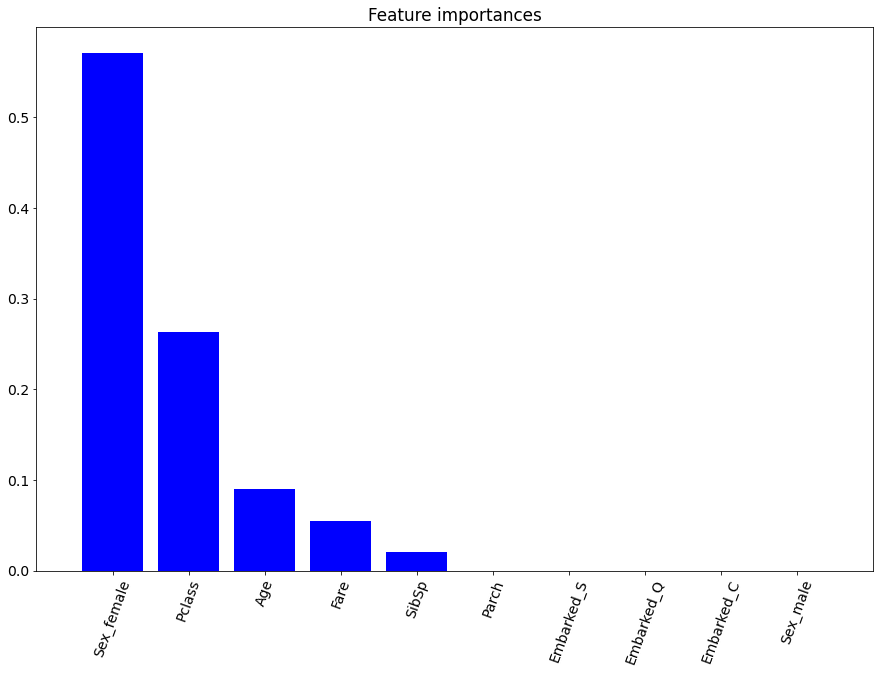

In [49]:
show_importance(tree, recovered_feat_names, X_train)

Линейная регрессия

In [50]:
from sklearn.linear_model import LinearRegression

# Создаем объект
reg = LinearRegression()
# Обучаем на выборке для обучения
reg.fit(X_train, y_train)
y_pred=np.round(reg.predict(X_test))
f1 = f1_score(y_test,y_pred)
print(f'f1_score={f1}')

f1_score=0.7384615384615385


## Модель дерева со стандартизацией

In [51]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
reg = LinearRegression()
# "Обучение" трансформера - определение параметров средних и отклонений
scaler.fit(X_train)

# Стандартизация данных
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

f1_score=0.7200000000000001
Feature: Sex_female | 0.5713000294628707
Feature: Sex_male | 0.0
Feature: Embarked_C | 0.0
Feature: Embarked_Q | 0.0
Feature: Embarked_S | 0.0
Feature: Pclass | 0.2632878756943254
Feature: Age | 0.08967439414171541
Feature: Fare | 0.05504374990907275
Feature: SibSp | 0.02069395079201579
Feature: Parch | 0.0


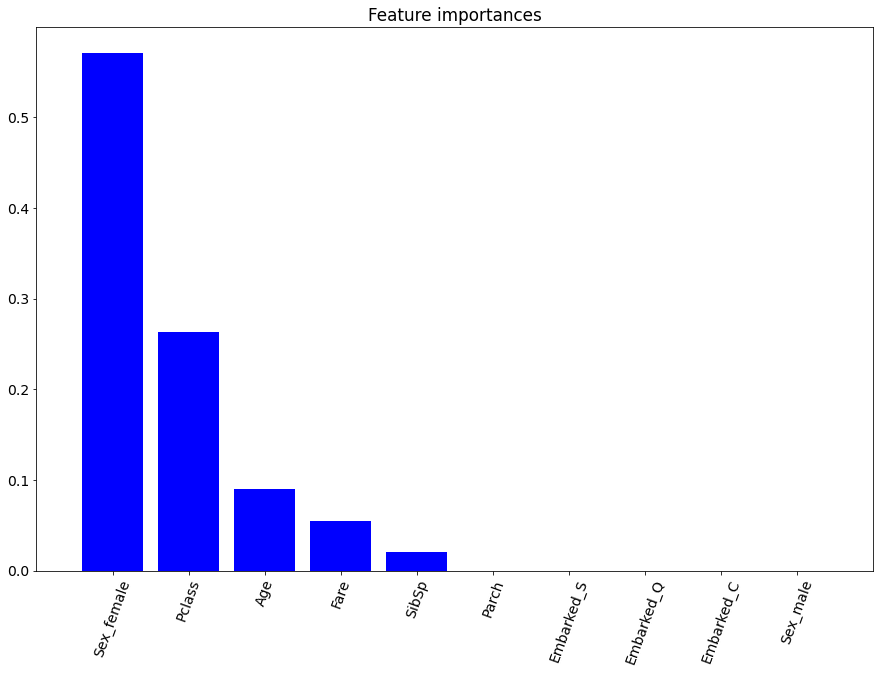

In [52]:
tree = DecisionTreeClassifier(random_state=RANDOM_STATE,max_depth=3,criterion='entropy')

tree.fit(X_train_scaled, y_train)
y_pred=tree.predict(X_test_scaled)
f1 = f1_score(y_test,y_pred)
print(f'f1_score={f1}')

show_importance(tree, recovered_feat_names, X_train_scaled)

модель линейной регрессии

In [53]:
# Создаем объект
reg = LinearRegression()
# Обучаем на выборке для обучения
reg.fit(X_train_scaled, y_train)
y_pred=np.round(reg.predict(X_test_scaled))
f1 = f1_score(y_test,y_pred)
print(f'f1_score={f1}')

f1_score=0.7244094488188977


после стандартизации можно заметить, что f1 линейной регресси уменьшился, что говорит о том, что работа модели ухудшилась. Также если анализировать графики важности признаков, то можно отметить, что Parch - количество родственников на борту (матери, отцы, дочери, сыновья) не оказывает влияния.

## Изучите влияние max_depth и criterion на показатели дерева, попробуйте 5 разных значений для каждого критерия, оцените с помощью кросс-валидации на обучающей выборке, сделайте таблицу;

In [58]:
from sklearn.model_selection import cross_val_score

f1_scores=np.ndarray([5,2])
criteria_eval={"gini", "entropy"}
max_depths=np.array(range(1,10,2))
step1=-1
for i in criteria_eval:
    step2=0
    step1=step1+1
    for j in max_depths:
        tree = DecisionTreeClassifier(random_state=RANDOM_STATE,max_depth=j,criterion=i)
        scores = cross_val_score(
            tree, # Модель для оценки
            X_data, # Данные для обучения
            y_data, # Разметка для обучения
            cv=5, # Количество фолдов
            scoring='f1_macro' # Желаемая метрика
        )
        f1_scores[step2,step1]=scores.mean();
        step2=step2+1

f1_data=pd.DataFrame(data=f1_scores,columns=criteria_eval,index=max_depths)
f1_data

,gini,entropy
1,0.770358,0.770358
3,0.789666,0.798474
5,0.793978,0.791622
7,0.791572,0.792793
9,0.793432,0.794862


Как видно из таблицы, максмиальная величина энтропии достигается при глубине дерева 3. Максимальная величина Джинни достигается при глубине 5. В целом, не имеет смысла брать большую глубину дерева. Достаточно будет и 3.

# Расширенный анализ данных

## Проведите создание новых признаков, добавляя каждый новый признак проведите оценку модели

In [60]:
new_df['FamilySize']=new_df['Parch']+new_df['SibSp']+1
isAlone=list();
for pers in new_df['FamilySize']:
    if pers==1: isAlone.append(1);
    else: isAlone.append(0);
new_df['isAlone']=isAlone
new_df['FarePerPerson']=new_df['Fare']/new_df['FamilySize']
print(new_df['FarePerPerson'])

0       3.62500
1      35.64165
2       7.92500
3      26.55000
4       8.05000
         ...   
886    13.00000
887    30.00000
888     5.86250
889    30.00000
890     7.75000
Name: FarePerPerson, Length: 891, dtype: float64


In [61]:
from sklearn.compose import ColumnTransformer
# Составляет список признаков для обработки
categorical_features = ['Sex', 'Embarked']
numeric_features = ['Pclass','Age', 'Fare','FamilySize']

# Создаем обработчик категориальных признаков
categorical_transformer = Pipeline(
    steps=[
        ('imp', SimpleImputer(strategy='most_frequent')),
        ('enc', OneHotEncoder(handle_unknown='error')),                   
])

# Численные значения имеют пропуски, заполним стратегией медианы
numeric_transformer = SimpleImputer(strategy='median')

# Создаем конечный конвертер, который будет использован для 
#   предобработки
preprocessor = ColumnTransformer(
    # Список конвертеров, каждый кортеж содержит
    #   имя, конвертер и признаки, на которые он будет применен
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numeric_transformer, numeric_features)
    ],
    # Признаки, не указанные ни в одном из конвертеров будут удалены
    remainder='drop'
)

preprocessor.fit(new_df)

X_data = preprocessor.transform(new_df)
print(type(X_data))

<class 'numpy.ndarray'>


In [62]:
from sklearn.model_selection import train_test_split

TRAIN_RATIO=0.8

y_data=new_df['Survived']

X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, 
    train_size=TRAIN_RATIO, 
    random_state=RANDOM_STATE,
    stratify=y_data
)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(712, 9) (712,)
(179, 9) (179,)


f1_score=0.7200000000000001
Feature: Sex_female | 0.0
Feature: Sex_male | 0.5693649875674883
Feature: Embarked_C | 0.0
Feature: Embarked_Q | 0.0
Feature: Embarked_S | 0.0
Feature: Pclass | 0.2623960972176224
Feature: Age | 0.08937065932522958
Feature: Fare | 0.017547499612378704
Feature: FamilySize | 0.06132075627728098


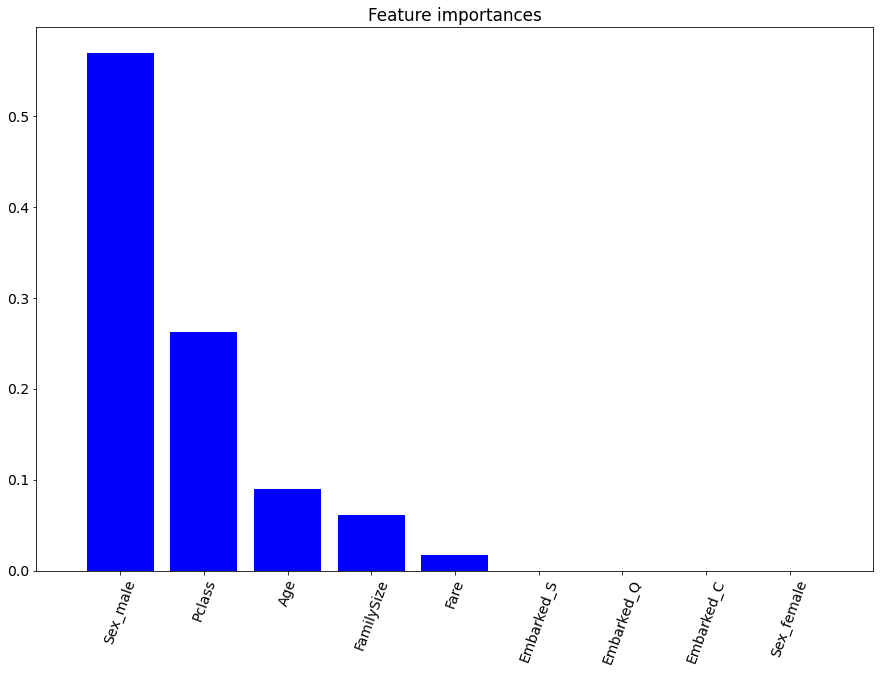

In [63]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import f1_score

tree = DecisionTreeClassifier(random_state=RANDOM_STATE,max_depth=3, criterion='entropy')
tree.fit(X_train, y_train)
y_pred=tree.predict(X_test)
f1 = f1_score(y_test,y_pred)
print(f'f1_score={f1}')
ohe_column_names = preprocessor \
    .named_transformers_['cat'] \
    .named_steps['enc'] \
    .get_feature_names(categorical_features)

recovered_feat_names = \
    list(ohe_column_names) + \
    list(numeric_features)
show_importance(tree, recovered_feat_names, X_train)

In [64]:
from sklearn.compose import ColumnTransformer
# Составляет список признаков для обработки
categorical_features = ['Sex', 'Embarked']
numeric_features = ['Pclass','Age', 'Fare','isAlone']

# Создаем обработчик категориальных признаков
categorical_transformer = Pipeline(
    steps=[
        ('imp', SimpleImputer(strategy='most_frequent')),
        ('enc', OneHotEncoder(handle_unknown='error')),                   
])

# Численные значения имеют пропуски, заполним стратегией медианы
numeric_transformer = SimpleImputer(strategy='median')

# Создаем конечный конвертер, который будет использован для 
#   предобработки
preprocessor = ColumnTransformer(
    # Список конвертеров, каждый кортеж содержит
    #   имя, конвертер и признаки, на которые он будет применен
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numeric_transformer, numeric_features)
    ],
    # Признаки, не указанные ни в одном из конвертеров будут удалены
    remainder='drop'
)

preprocessor.fit(new_df)

X_data = preprocessor.transform(new_df)
print(type(X_data))

<class 'numpy.ndarray'>


In [65]:
from sklearn.model_selection import train_test_split

TRAIN_RATIO=0.8

y_data=new_df['Survived']

X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, 
    train_size=TRAIN_RATIO, 
    random_state=RANDOM_STATE,
    stratify=y_data
)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(712, 9) (712,)
(179, 9) (179,)


f1_score=0.703125
Feature: Sex_female | 0.0
Feature: Sex_male | 0.5770283076941427
Feature: Embarked_C | 0.0
Feature: Embarked_Q | 0.0
Feature: Embarked_S | 0.0
Feature: Pclass | 0.27680249670337287
Feature: Age | 0.09057353619207983
Feature: Fare | 0.055595659410404605
Feature: isAlone | 0.0


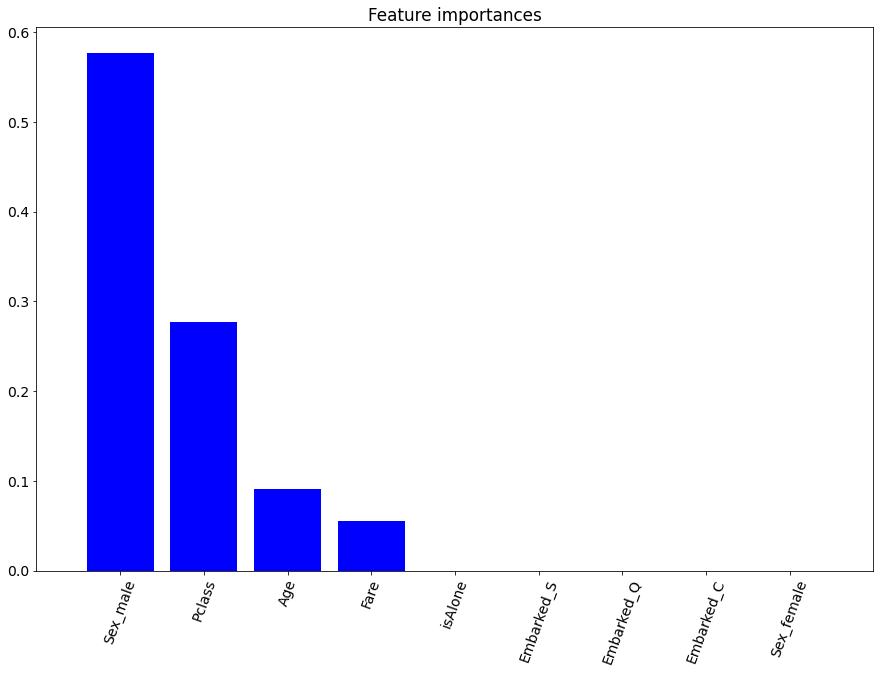

In [66]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import f1_score

tree = DecisionTreeClassifier(random_state=RANDOM_STATE,max_depth=3, criterion='entropy')
tree.fit(X_train, y_train)
y_pred=tree.predict(X_test)
f1 = f1_score(y_test,y_pred)
print(f'f1_score={f1}')
ohe_column_names = preprocessor \
    .named_transformers_['cat'] \
    .named_steps['enc'] \
    .get_feature_names(categorical_features)

recovered_feat_names = \
    list(ohe_column_names) + \
    list(numeric_features)
show_importance(tree, recovered_feat_names, X_train)

In [67]:
from sklearn.compose import ColumnTransformer
# Составляет список признаков для обработки
categorical_features = ['Sex', 'Embarked']
numeric_features=['Pclass','Age', 'Fare','FarePerPerson']

# Создаем обработчик категориальных признаков
categorical_transformer = Pipeline(
    steps=[
        ('imp', SimpleImputer(strategy='most_frequent')),
        ('enc', OneHotEncoder(handle_unknown='error')),                   
])

# Численные значения имеют пропуски, заполним стратегией медианы
numeric_transformer = SimpleImputer(strategy='median')

# Создаем конечный конвертер, который будет использован для 
#   предобработки
preprocessor = ColumnTransformer(
    # Список конвертеров, каждый кортеж содержит
    #   имя, конвертер и признаки, на которые он будет применен
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numeric_transformer, numeric_features)
    ],
    # Признаки, не указанные ни в одном из конвертеров будут удалены
    remainder='drop'
)

preprocessor.fit(new_df)

X_data = preprocessor.transform(new_df)
print(type(X_data))

<class 'numpy.ndarray'>


In [68]:
from sklearn.model_selection import train_test_split

TRAIN_RATIO=0.8

y_data=new_df['Survived']

X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, 
    train_size=TRAIN_RATIO, 
    random_state=RANDOM_STATE,
    stratify=y_data
)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(712, 9) (712,)
(179, 9) (179,)


f1_score=0.7132867132867132
Feature: Sex_female | 0.0
Feature: Sex_male | 0.5449683534396205
Feature: Embarked_C | 0.0
Feature: Embarked_Q | 0.0
Feature: Embarked_S | 0.0
Feature: Pclass | 0.17912180325816726
Feature: Age | 0.10302492843666713
Feature: Fare | 0.05250673938051876
Feature: FarePerPerson | 0.12037817548502637


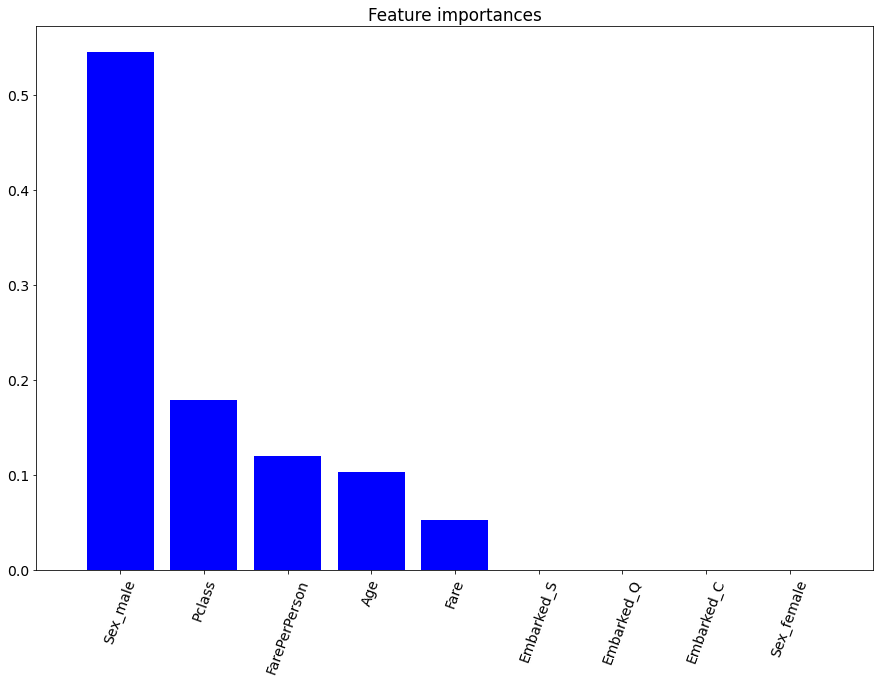

In [69]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import f1_score

tree = DecisionTreeClassifier(random_state=RANDOM_STATE,max_depth=3, criterion='entropy')
tree.fit(X_train, y_train)
y_pred=tree.predict(X_test)
f1 = f1_score(y_test,y_pred)
print(f'f1_score={f1}')
ohe_column_names = preprocessor \
    .named_transformers_['cat'] \
    .named_steps['enc'] \
    .get_feature_names(categorical_features)

recovered_feat_names = \
    list(ohe_column_names) + \
    list(numeric_features)
show_importance(tree, recovered_feat_names, X_train)

Были сгруппированы и добавлены следующие признаки: FamilySize - размер родственников на корабле; IsAlone - является ли пассажир один на корабле или нет (бинарный признак); FarePerPerson - оплата билета на человека в семье (воспользоваться FamilySize). Признак  IsAlone никак не влияет на выживаемость. При этом признаки FarePerPerson и FamilySize оказывают  влияние на выживаемость на равне с полом (sex_male), классом (Pclass), возрастом (Age) и платой за проезд (fare)

для большей наглядности посмотрим все признаки на одном графике

In [70]:
from sklearn.compose import ColumnTransformer
# Составляет список признаков для обработки
categorical_features = ['Sex', 'Embarked']
numeric_features = ['Pclass','Age', 'Fare','FamilySize','FarePerPerson','isAlone']

# Создаем обработчик категориальных признаков
categorical_transformer = Pipeline(
    steps=[
        ('imp', SimpleImputer(strategy='most_frequent')),
        ('enc', OneHotEncoder(handle_unknown='error')),                   
])

# Численные значения имеют пропуски, заполним стратегией медианы
numeric_transformer = SimpleImputer(strategy='median')

# Создаем конечный конвертер, который будет использован для 
#   предобработки
preprocessor = ColumnTransformer(
    # Список конвертеров, каждый кортеж содержит
    #   имя, конвертер и признаки, на которые он будет применен
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numeric_transformer, numeric_features)
    ],
    # Признаки, не указанные ни в одном из конвертеров будут удалены
    remainder='drop'
)

preprocessor.fit(new_df)

X_data = preprocessor.transform(new_df)
print(type(X_data))

<class 'numpy.ndarray'>


In [71]:
from sklearn.model_selection import train_test_split

TRAIN_RATIO=0.8

y_data=new_df['Survived']

X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, 
    train_size=TRAIN_RATIO, 
    random_state=RANDOM_STATE,
    stratify=y_data
)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(712, 11) (712,)
(179, 11) (179,)


f1_score=0.7132867132867132
Feature: Sex_female | 0.0
Feature: Sex_male | 0.543207301153105
Feature: Embarked_C | 0.0
Feature: Embarked_Q | 0.0
Feature: Embarked_S | 0.0
Feature: Pclass | 0.17854297540660188
Feature: Age | 0.10269200582814068
Feature: Fare | 0.016741334845946334
Feature: FamilySize | 0.03882720649525601
Feature: FarePerPerson | 0.11998917627095007
Feature: isAlone | 0.0


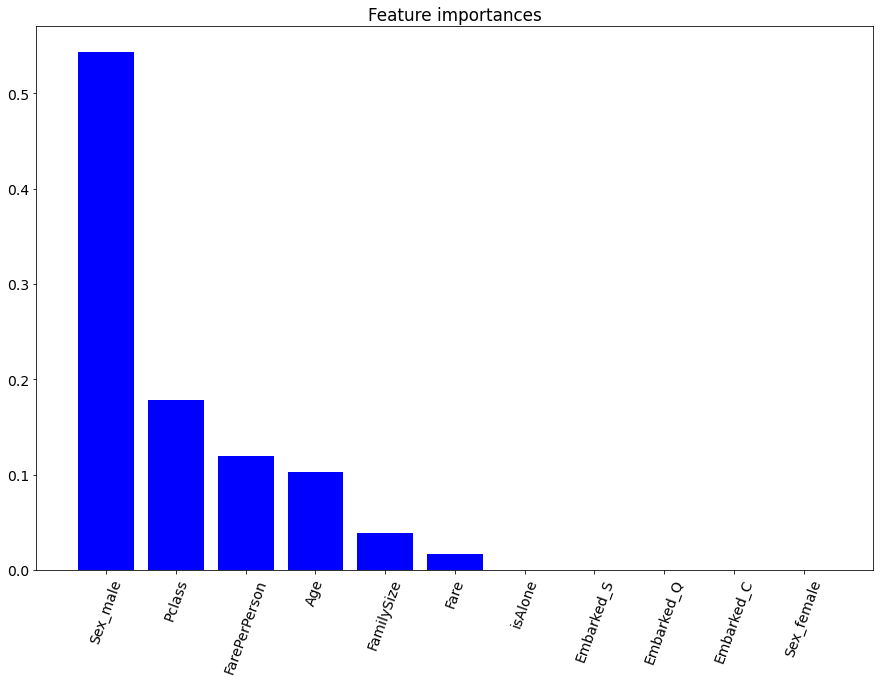

In [72]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import f1_score

tree = DecisionTreeClassifier(random_state=RANDOM_STATE,max_depth=3, criterion='entropy')
tree.fit(X_train, y_train)
y_pred=tree.predict(X_test)
f1 = f1_score(y_test,y_pred)
print(f'f1_score={f1}')
ohe_column_names = preprocessor \
    .named_transformers_['cat'] \
    .named_steps['enc'] \
    .get_feature_names(categorical_features)

recovered_feat_names = \
    list(ohe_column_names) + \
    list(numeric_features)
show_importance(tree, recovered_feat_names, X_train)

Как видно из графика, самое сильное влияние оказывает пол и класс. Далее идет смешанный признак FarePerPerson и возраст пассажира. Самое маленькое влияние оказывает оплата проезда.

## Оцените работу модели при добавлении группировки признаков Age, Fare;

[array([  0.    ,   7.55  ,   7.8542,   8.05  ,  10.5   ,  14.4542,
        21.6792,  27.    ,  39.6875,  77.9583, 512.3292])]
(891, 1)
[array([ 0.42      , 16.        , 20.        , 24.        , 28.        ,
       29.69911765, 32.5       , 38.        , 47.        , 80.        ])]


C:\Users\ksyus\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:200: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '


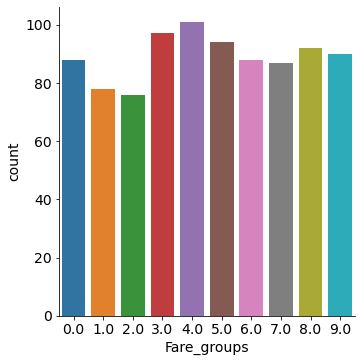

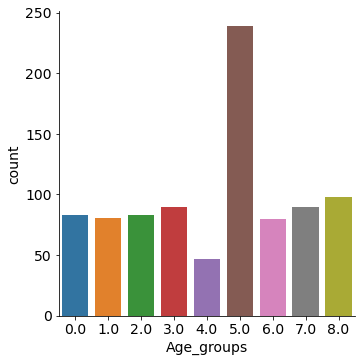

In [74]:
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.impute import SimpleImputer

discr = KBinsDiscretizer(
    # Количество бинов
    n_bins=10,
    # Способ кодирования - порядковый
    encode='ordinal',
)

# Двойные скобки для передачи DataFrame (2D данные)
new_df['Fare_groups'] = discr.fit_transform(new_df[['Fare']])
# Отобразим границы бинов
print(discr.bin_edges_)
sns.catplot(x='Fare_groups', kind="count", data=new_df)

imp = SimpleImputer(strategy='mean')
# Двойные скобки использованы, чтобы передать в fit() 2D массив
X_in = new_df[['Age']]
print(X_in.shape)

new_df['Age'] = imp.fit_transform(X_in)
new_df.isnull().sum()
discr = KBinsDiscretizer(
    # Количество бинов
    n_bins=10,
    # Способ кодирования - порядковый
    encode='ordinal',
)

# Двойные скобки для передачи DataFrame (2D данные)
new_df['Age_groups'] = discr.fit_transform(new_df[['Age']])
# Отобразим границы бинов
print(discr.bin_edges_)
sns.catplot(x='Age_groups', kind="count", data=new_df)

In [75]:
from sklearn.compose import ColumnTransformer
# Составляет список признаков для обработки
categorical_features = ['Sex', 'Embarked']
numeric_features = ['Pclass','Age_groups', 'Fare_groups']

# Создаем обработчик категориальных признаков
categorical_transformer = Pipeline(
    steps=[
        ('imp', SimpleImputer(strategy='most_frequent')),
        ('enc', OneHotEncoder(handle_unknown='error')),                   
])

# Численные значения имеют пропуски, заполним стратегией медианы
numeric_transformer = SimpleImputer(strategy='median')

# Создаем конечный конвертер, который будет использован для 
#   предобработки
preprocessor = ColumnTransformer(
    # Список конвертеров, каждый кортеж содержит
    #   имя, конвертер и признаки, на которые он будет применен
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numeric_transformer, numeric_features)
    ],
    # Признаки, не указанные ни в одном из конвертеров будут удалены
    remainder='drop'
)

preprocessor.fit(new_df)

X_data = preprocessor.transform(new_df)
print(type(X_data))

<class 'numpy.ndarray'>


In [76]:
from sklearn.model_selection import train_test_split

TRAIN_RATIO=0.8

y_data=new_df['Survived']

X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, 
    train_size=TRAIN_RATIO, 
    random_state=RANDOM_STATE,
    stratify=y_data
)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(712, 8) (712,)
(179, 8) (179,)


f1_score=0.6842105263157895
Feature: Sex_female | 0.6243974551151824
Feature: Sex_male | 0.0
Feature: Embarked_C | 0.0
Feature: Embarked_Q | 0.0
Feature: Embarked_S | 0.03814382675580773
Feature: Pclass | 0.2282775813563417
Feature: Age_groups | 0.02612783462897275
Feature: Fare_groups | 0.08305330214369552


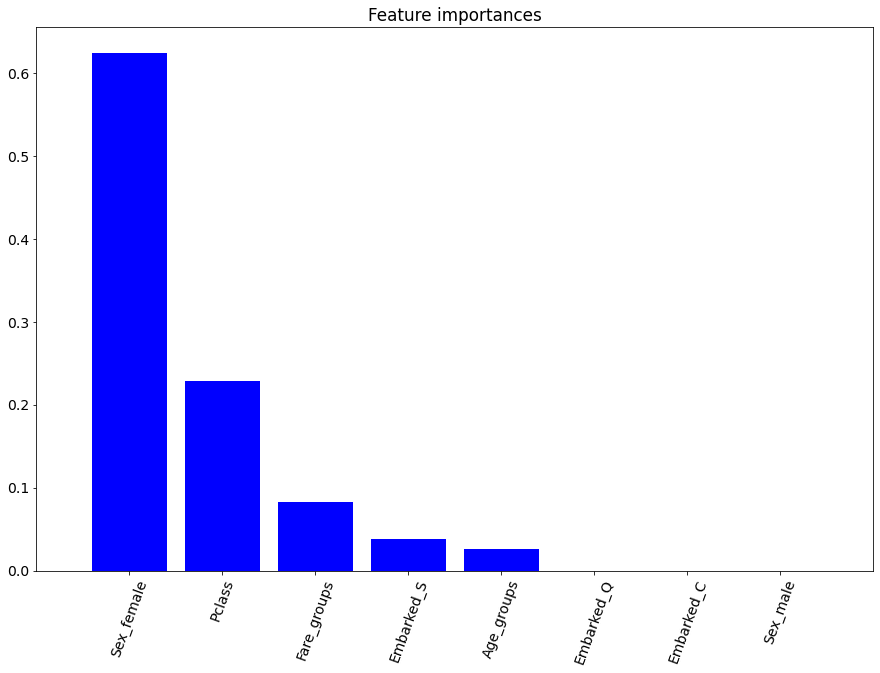

In [77]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import f1_score

tree = DecisionTreeClassifier(random_state=RANDOM_STATE,max_depth=3, criterion='entropy')
tree.fit(X_train, y_train)
y_pred=tree.predict(X_test)
f1 = f1_score(y_test,y_pred)
print(f'f1_score={f1}')
ohe_column_names = preprocessor \
    .named_transformers_['cat'] \
    .named_steps['enc'] \
    .get_feature_names(categorical_features)

recovered_feat_names = \
    list(ohe_column_names) + \
    list(numeric_features)
show_importance(tree, recovered_feat_names, X_train)

In [78]:
from sklearn.compose import ColumnTransformer
# Составляет список признаков для обработки
categorical_features = ['Sex', 'Embarked']
numeric_features = ['Pclass','Age_groups', 'Fare_groups','FamilySize','FarePerPerson']

# Создаем обработчик категориальных признаков
categorical_transformer = Pipeline(
    steps=[
        ('imp', SimpleImputer(strategy='most_frequent')),
        ('enc', OneHotEncoder(handle_unknown='error')),                   
])

# Численные значения имеют пропуски, заполним стратегией медианы
numeric_transformer = SimpleImputer(strategy='median')

# Создаем конечный конвертер, который будет использован для 
#   предобработки
preprocessor = ColumnTransformer(
    # Список конвертеров, каждый кортеж содержит
    #   имя, конвертер и признаки, на которые он будет применен
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numeric_transformer, numeric_features)
    ],
    # Признаки, не указанные ни в одном из конвертеров будут удалены
    remainder='drop'
)

preprocessor.fit(new_df)

X_data = preprocessor.transform(new_df)
print(type(X_data))

<class 'numpy.ndarray'>


In [79]:
from sklearn.model_selection import train_test_split

TRAIN_RATIO=0.8

y_data=new_df['Survived']

X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, 
    train_size=TRAIN_RATIO, 
    random_state=RANDOM_STATE,
    stratify=y_data
)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(712, 10) (712,)
(179, 10) (179,)


f1_score=0.7285714285714284
Feature: Sex_female | 0.5676113665895944
Feature: Sex_male | 0.0
Feature: Embarked_C | 0.0
Feature: Embarked_Q | 0.0
Feature: Embarked_S | 0.0
Feature: Pclass | 0.1865641755005604
Feature: Age_groups | 0.06417715220424883
Feature: Fare_groups | 0.0
Feature: FamilySize | 0.04057155287280819
Feature: FarePerPerson | 0.1410757528327881


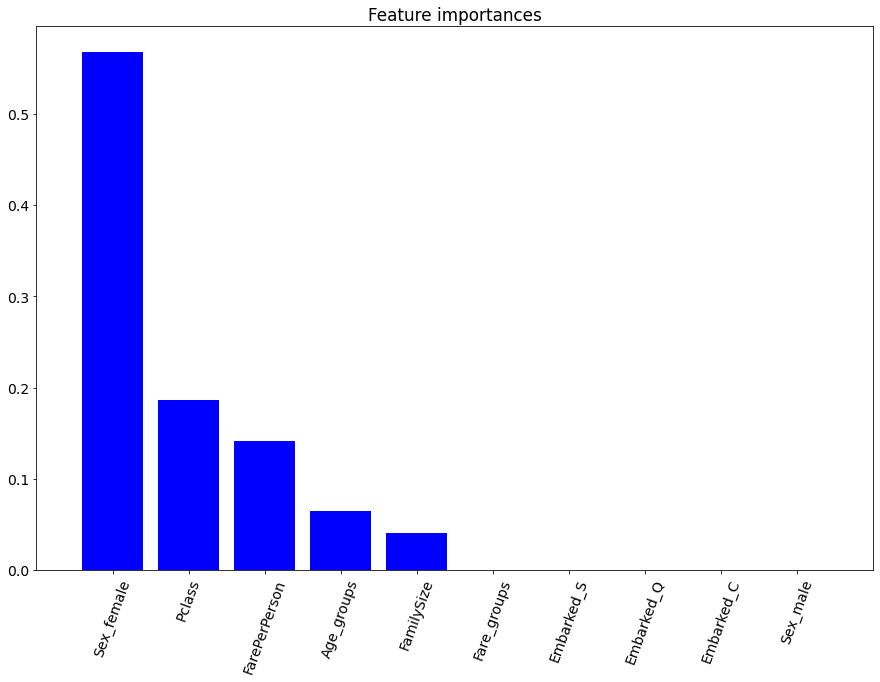

In [80]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import f1_score

tree = DecisionTreeClassifier(random_state=RANDOM_STATE,max_depth=3, criterion='entropy')
tree.fit(X_train, y_train)
y_pred=tree.predict(X_test)
f1 = f1_score(y_test,y_pred)
print(f'f1_score={f1}')
ohe_column_names = preprocessor \
    .named_transformers_['cat'] \
    .named_steps['enc'] \
    .get_feature_names(categorical_features)

recovered_feat_names = \
    list(ohe_column_names) + \
    list(numeric_features)
show_importance(tree, recovered_feat_names, X_train)

In [81]:
from sklearn.compose import ColumnTransformer
# Составляет список признаков для обработки
categorical_features = ['Sex', 'Embarked']
numeric_features = ['Pclass','Age_groups', 'Fare_groups','FamilySize']

# Создаем обработчик категориальных признаков
categorical_transformer = Pipeline(
    steps=[
        ('imp', SimpleImputer(strategy='most_frequent')),
        ('enc', OneHotEncoder(handle_unknown='error')),                   
])

# Численные значения имеют пропуски, заполним стратегией медианы
numeric_transformer = SimpleImputer(strategy='median')

# Создаем конечный конвертер, который будет использован для 
#   предобработки
preprocessor = ColumnTransformer(
    # Список конвертеров, каждый кортеж содержит
    #   имя, конвертер и признаки, на которые он будет применен
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numeric_transformer, numeric_features)
    ],
    # Признаки, не указанные ни в одном из конвертеров будут удалены
    remainder='drop'
)

preprocessor.fit(new_df)

X_data = preprocessor.transform(new_df)
print(type(X_data))

<class 'numpy.ndarray'>


In [82]:
from sklearn.model_selection import train_test_split

TRAIN_RATIO=0.8

y_data=new_df['Survived']

X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, 
    train_size=TRAIN_RATIO, 
    random_state=RANDOM_STATE,
    stratify=y_data
)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(712, 9) (712,)
(179, 9) (179,)


f1_score=0.7301587301587301
Feature: Sex_female | 0.0
Feature: Sex_male | 0.6151718074311925
Feature: Embarked_C | 0.0
Feature: Embarked_Q | 0.0
Feature: Embarked_S | 0.0
Feature: Pclass | 0.20219648125470416
Feature: Age_groups | 0.025741788537564533
Feature: Fare_groups | 0.08182616628929273
Feature: FamilySize | 0.07506375648724622


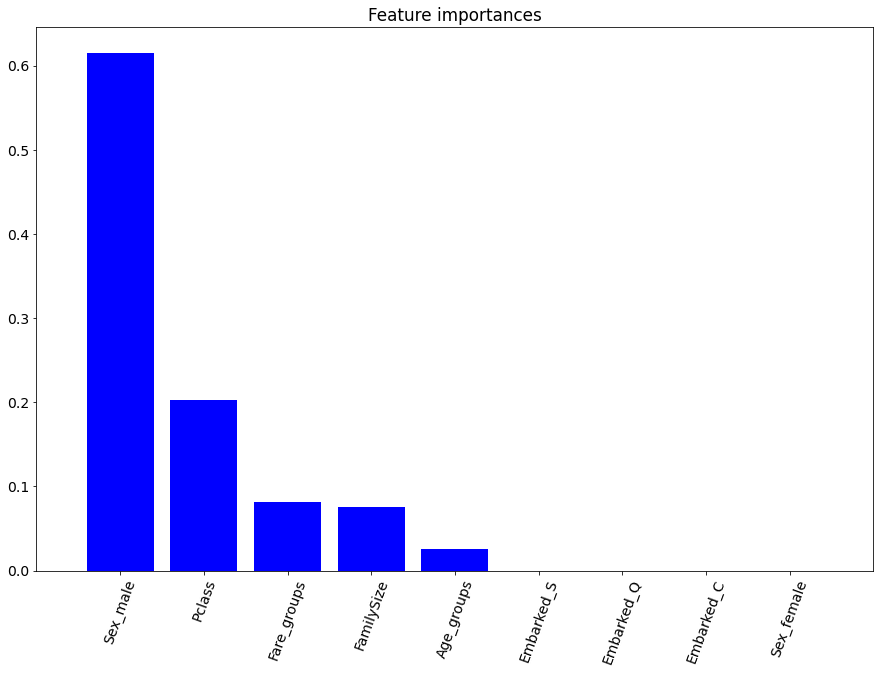

In [83]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import f1_score

tree = DecisionTreeClassifier(random_state=RANDOM_STATE,max_depth=3, criterion='entropy')
tree.fit(X_train, y_train)
y_pred=tree.predict(X_test)
f1 = f1_score(y_test,y_pred)
print(f'f1_score={f1}')
ohe_column_names = preprocessor \
    .named_transformers_['cat'] \
    .named_steps['enc'] \
    .get_feature_names(categorical_features)

recovered_feat_names = \
    list(ohe_column_names) + \
    list(numeric_features)
show_importance(tree, recovered_feat_names, X_train)

Наилучшего показателя f1 удалось добиться при использовании следующей комбинации признаков: 'Pclass','Age_groups', 'Fare_groups','FamilySize'.

## Обучите модель дерева и модель леса RandomForestClassifier по подготовленным данным;

так как ранее уже была получена стратификация с признаками, дающими хороший f1, то далее будем использовать ее для обчения модели леса

f1_score=0.7200000000000001
Feature: Sex_female | 0.3920656309870334
Feature: Sex_male | 0.2315452163152832
Feature: Embarked_C | 0.008942453614813863
Feature: Embarked_Q | 0.004714031825758371
Feature: Embarked_S | 0.0171572080981222
Feature: Pclass | 0.1570537772191611
Feature: Age_groups | 0.028490902043675884
Feature: Fare_groups | 0.08989941535770259
Feature: FamilySize | 0.07013136453844945


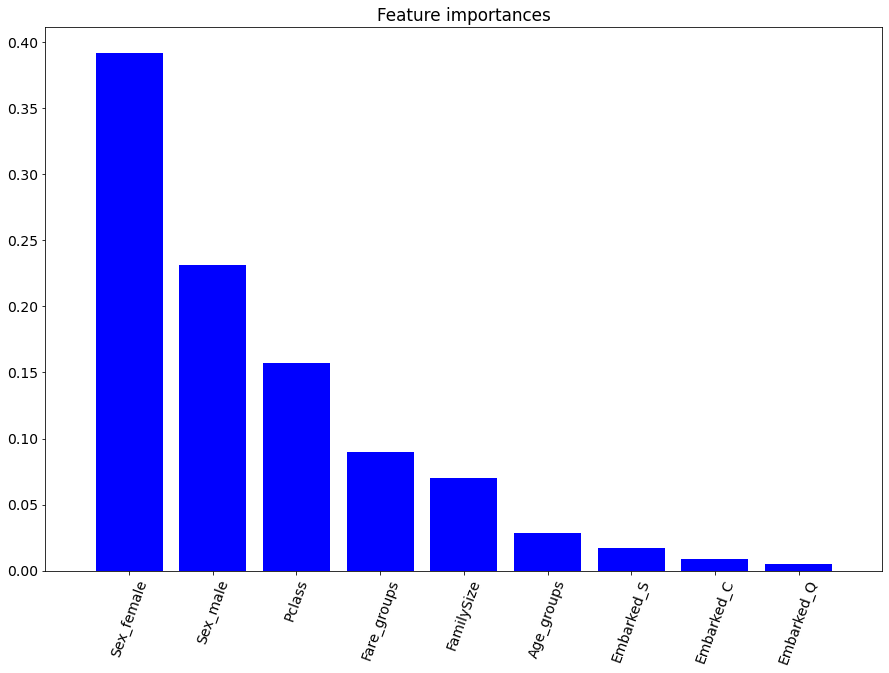

In [84]:
from sklearn.ensemble import RandomForestClassifier

new_forest = RandomForestClassifier(max_depth=3,criterion='entropy')
new_forest.fit(X_train, y_train)
y_pred=new_forest.predict(X_test)
f1=f1_score(y_test,y_pred)
print(f'f1_score={f1}')
show_importance(new_forest, recovered_feat_names, X_train)

## Оцените влияние аргументов max_depth и n_estimators на точность модели (5 значений для каждого) с помощью кросс-валидации на обучающей выборке. Постройте таблицу зависимости метрик от величин;

In [87]:
f1_scores=np.ndarray([5,5])
n_estimators=np.array(range(1,20,4))
max_depths=np.array(range(1,10,2))
step1=-1
for i in n_estimators:
    step2=0
    step1=step1+1
    for j in max_depths:
        new_forest = RandomForestClassifier(max_depth=j,criterion='entropy',n_estimators=i)
        scores = cross_val_score(
            new_forest, # Модель для оценки
            X_data, # Данные для обучения
            y_data, # Разметка для обучения
            cv=5, # Количество фолдов
            scoring='f1_macro' # Желаемая метрика
        )
        f1_scores[step2,step1]=scores.mean();
        step2=step2+1
        
f1_data=pd.DataFrame(data=f1_scores,columns=n_estimators,index=max_depths)
f1_data

,1,5,9,13,17
1,0.754189,0.738995,0.763444,0.743011,0.765698
3,0.774852,0.792259,0.793214,0.791334,0.785723
5,0.791440,0.795287,0.802118,0.803337,0.800026
7,0.782869,0.808560,0.791169,0.796986,0.802939
9,0.761972,0.781101,0.800457,0.811796,0.811529


Оптимальная глубина дерева может быть выбрана равной либо 3, либо 5. При этом количество деревьев больше 5 существенно не влияет на результат. Но стоит отметить, что и максимально возможное количество деревьев не такое уж и большое (здесь оно равно 17). Если его увеличить, то будет заметно, что параметр f1 ухудшится при очень большом количестве деревьев (переобучение). Оптимально выбрать где-то от 5 до до 13 деревьев.

## Определите наилучшие параметры для модели случайного леса через GridSearchCV;

In [94]:
from sklearn.model_selection import GridSearchCV
new_forest = RandomForestClassifier( )
parameters = {
    'max_depth': [1, 3, 5, 7, 9],
    'n_estimators': [1, 5, 9, 13, 17],
}

grid_search = GridSearchCV(
    # модель
    estimator=new_forest,                   
    # сетка параметров
    #   может быть объектом dict 
    #   или list с несколькими dict внутри (несколько сеток)
    param_grid=parameters,              
    # кол-во фолдов для CV
    cv=5,                               
    # метрика для оценки - используем F1 
    scoring='f1_macro',   
)

grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)

{'max_depth': 5, 'n_estimators': 9}
0.8114016694354269


В данном случае при максимальной глубине дерева 5 и количестве деревьев 9 показатель f1 лучше, чем в предыдщуем случае. 

## Определите наилучшие параметры для модели случайного леса через RandomizedSearchCV;

In [92]:
from sklearn.model_selection import RandomizedSearchCV

new_forest = RandomForestClassifier( )

parameters = {
    'max_depth': [1, 3, 5, 7, 9],
    'n_estimators': [1, 5, 9, 13, 17]
}

rand_search = RandomizedSearchCV(
    estimator=new_forest,                   
    param_distributions=parameters,              

    cv=5,                                
    scoring='f1_macro',   
)

rand_search.fit(X_train, y_train)
print(rand_search.best_params_)
print(rand_search.best_score_)

{'n_estimators': 9, 'max_depth': 9}
0.8048097238425782


Результат хуже, чем при использовании GridSearchCV

## Постройте лучшие модели леса и решающего дерева и сравните их по показателям на выборке для теста.

In [95]:
new_forest = RandomForestClassifier(max_depth=5,criterion='gini',n_estimators=9)
new_forest.fit(X_train, y_train)
y_pred=new_forest.predict(X_test)
f1 = f1_score(y_test,y_pred)
print(f'f1_score={f1}')

tree = DecisionTreeClassifier(max_depth=3,criterion='entropy')
tree.fit(X_train, y_train)
y_pred=tree.predict(X_test)
f1 = f1_score(y_test,y_pred)
print(f'f1_score={f1}')

f1_score=0.7538461538461538
f1_score=0.7301587301587301


Как видно, лес дал лучший результат по f1

## Примените подход Recursive Feature Elimination на лучшую модель случайного леса. Сравните оценку важности признаков RFE и то, что показывает лес.

In [96]:
from sklearn.datasets import make_friedman1
from sklearn.feature_selection import RFE
from sklearn.svm import SVR

estimator = SVR(kernel="linear")
selector = RFE(estimator=estimator,n_features_to_select=7, step=1)
selector = selector.fit(X_data, y_data)
top_7=selector.support_
print(selector.support_)
print(selector.ranking_)

selector = RFE(estimator=estimator,n_features_to_select=5, step=1)
selector = selector.fit(X_data, y_data)
top_5=selector.support_
print(selector.support_)
print(selector.ranking_)

[ True  True  True  True  True  True False False  True]
[1 1 1 1 1 1 2 3 1]
[ True  True False  True  True False False False  True]
[1 1 3 1 1 2 4 5 1]


In [98]:
print(np.array(recovered_feat_names)[top_5])
print(np.array(recovered_feat_names)[top_7])
print(recovered_feat_names)

['Sex_female' 'Sex_male' 'Embarked_Q' 'Embarked_S' 'FamilySize']
['Sex_female' 'Sex_male' 'Embarked_C' 'Embarked_Q' 'Embarked_S' 'Pclass'
 'FamilySize']
['Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Pclass', 'Age_groups', 'Fare_groups', 'FamilySize']


Ранее была получена лучшая модель случаного леса со следующими признаками: categorical_features = 'Sex', 'Embarked'
numeric_features = 'Pclass','Age_groups', 'Fare_groups','FamilySize'. При этом если посмотреть на тот график, то там был следующий порядок важности: Sex_female, Sex_male, Pclass, Fare_groups,FamilySize, Age_groups,Embarked_S, Embarked_С, Embarked_Q. 
в топ5 и топ7 верно установлена важность признаков Sex_female, Sex_male, но вот дальше что-то пошло не так.. По крайней мере, самые важные признаки установлены верно

## Постройте ROC кривые моделей

**1. лучшая модель на всех признаках**

**2.лучшая модель только на топ-7 лучших признаках по RFE**

**3.лучшая модель на топ-5 лучших признаках по RFE**

In [99]:
TRAIN_RATIO = 0.8
X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, 
    train_size=TRAIN_RATIO, 
    random_state=RANDOM_STATE,
    stratify=y_data
)
X_test_7=X_test[:,top_7]
X_test_5=X_test[:,top_5]
X_train_7=X_train[:,top_7]
X_train_5=X_train[:,top_5]

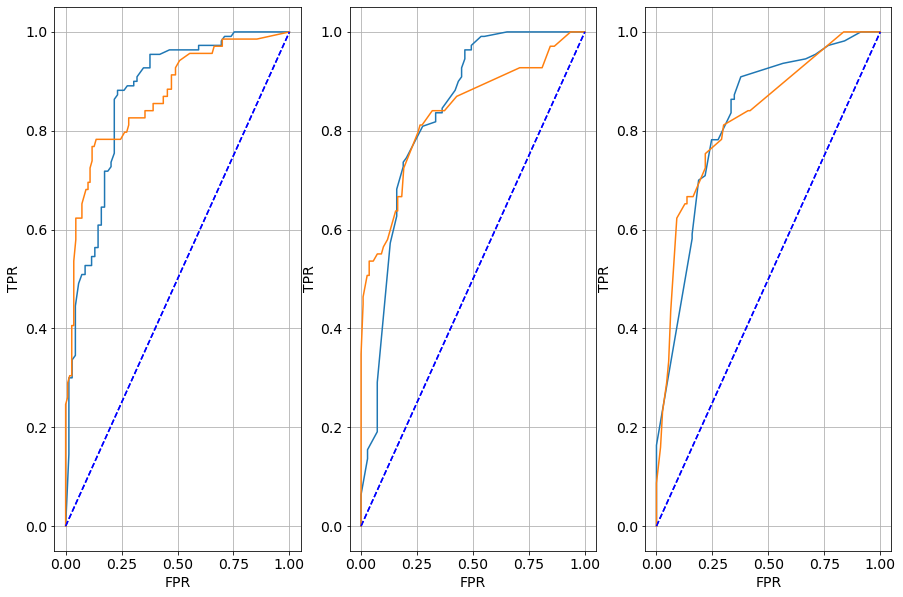

In [100]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

diag_values = np.array([
        [0, 0],
        [1, 1],
    ])

new_forest=RandomForestClassifier()
new_forest.fit(X_train,y_train)
y_pred_proba = new_forest.predict_proba(X_test)
plt.subplot(131)

for i in range (2):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,i],pos_label=i)
    plt.plot(fpr, tpr)
    plt.plot(diag_values[:,0], diag_values[:,1], 'b--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.grid(True)
    
new_forest=RandomForestClassifier()
new_forest.fit(X_train_7,y_train)
y_pred_proba = new_forest.predict_proba(X_test_7)
plt.subplot(132)

for i in range (2):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,i],pos_label=i)
    plt.plot(fpr, tpr)
    plt.plot(diag_values[:,0], diag_values[:,1], 'b--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.grid(True)
    
new_forest=RandomForestClassifier()
new_forest.fit(X_train_5,y_train)
y_pred_proba = new_forest.predict_proba(X_test_5)
plt.subplot(133)

for i in range (2):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,i],pos_label=i)
    plt.plot(fpr, tpr)
    plt.plot(diag_values[:,0], diag_values[:,1], 'b--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.grid(True)

# Вопросы

**1. Какой метод оценки модели лучше использовать в данной работе? Разделение на обучение/тест или кросс-валидация? Можно/нужно ли применять их вместе?** - В рамках данной работы наилучший показатель f1 был достигнут при использовании кросс-валидации и применении GridSearchCV. Метод разделения на обучение/тест является достаточно важным для применения, так как он позволяет оценить работу модели по данным, которые не были использованы в обучении. Тем не менее при малом объеме данных случайная тестовая выборка может быть слишком смещена и оценка будет искажена. Поэтому для того, чтобы произвести усредненную оценку на всем объеме данных, существует метод, названный К-фолд кросс-валидаци

**2. За что отвечают параметры max_depth и n_estimators в модели случайных лесов? Как они влияют на работу модели?** - max_depth это глубина дерева максимальная (т.е. число узлов этого дерева), n_estimators -количество деревьев в лесу. Если взять эти числа слишком большими, то можно переобучить модель и ее работа будет некорректной. Если же брать очень малые числа (к примеру, в работе тестировалась модель с использованием 1 узла и 1 дерева), то снова столкнемся с тем, что ухудшается качество работы модели.

**3. В чем отличие GridSearch от RandomSearch?** -  В отличие от GridSearchCV, не все значения параметров проверяются, а только фиксированное количество параметров выбирается из указанных распределений. Число параметров задается n_iter.

**4. Как влияет стандартизация признаков на работу модели леса?** - Как было указано выше, в целом станадартизация не оказала существенного влияния на работу модели дерева.

**5. Что такое "важность признака"? Есть ли аналоги показателя в моделях линейной и логистической регрессии?** - Важность признака влияет на конечный результат. Если обратиться к нашему примеру с Титаником, то в первую очередь спасали женщин и детей, причем в основном из богатых семей (кто ехал в высоком классе). Вот и получается, что пол,по-сути, важнейший признак, уже только зная его можно примерно предсказать выжил человек или нет. А вот если рассмотреть признак количество родственников на корабле, то тут уже только по нему явно и не скажешь как обернулась судьба человека. В линейной регрессии важные признаки мы выделяли с помощью веса, т.е. чем больше вес признака тем он важнее для нас.